# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [26]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

**Explain how you solve the model**

In [27]:
# code for solving the model (remember documentation and comments)

from HouseholdSpecializationModel import HouseholdSpecializationModelClass

# Laver nu interaktiv figur
# a. import
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import ipywidgets as widgets

# b. plotting figure
def interactive_figure(X, sigma_guess, alpha_guess):
    
    # i. normal distribution from guess
    F = norm(loc=alpha_guess,scale=sigma_guess)
    
    # ii. x-values
    x_low = F.ppf(0.001)
    x_high = F.ppf(0.999)
    x = np.linspace(x_low,x_high,100)

    # iii. figure
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.plot(x,F.pdf(x),lw=2)
    ax.hist(X,bins=100,density=True,histtype='stepfilled');
    ax.set_ylim([0,0.5])
    ax.set_xlim([-6,6])

# c. parameters
alpha_true = 0.5
sigma_true = 1
alpha_guess = 1
sigma_guess = 0.5

# d. random draws
X = np.random.normal(loc=alpha_true,scale=sigma_true,size=10**6)

# e. interactive
widgets.interact(interactive_figure,
    X=widgets.fixed(X),
    alpha_guess=widgets.FloatSlider(description="alpha_guess", min=0.25, max=0.75, step=0.25, value=1), 
    sigma_guess=widgets.FloatSlider(description="sigma_guess", min=0.5, max=1.5, step=0.25, value=1), 
);

interactive(children=(FloatSlider(value=1.0, description='sigma_guess', max=1.5, min=0.5, step=0.25), FloatSli…

/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida/inauguralproject/HouseholdSpecializationModel.py:64: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida/inauguralproject/HouseholdSpecializationModel.py:64: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida/inauguralproject/HouseholdSpecializationModel.py:68: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


        0     1     2
  0  0.545 0.308 0.214
  1  1.000 1.000 1.000
  2  1.833 3.250 4.667


Text(0, 0.5, '$HF$')

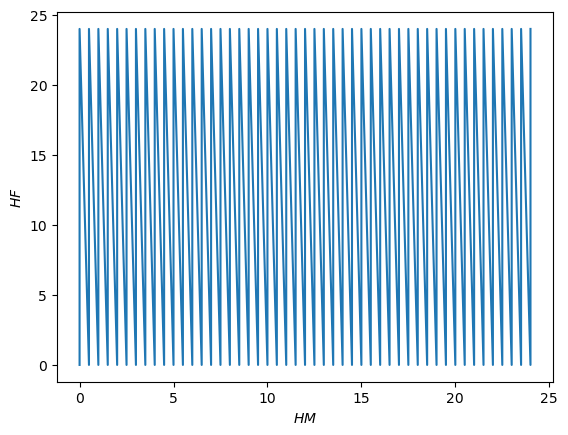

In [35]:
# code for solving the model (remember documentation and comments)

from HouseholdSpecializationModel import HouseholdSpecializationModelClass as HC

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import ipywidgets as widgets

alpha = [0.25, 0.50, 0.75]
sigma = [0.50, 1.00, 1.50]

test = HC() # Her trækker vi på funktionerne eller class

def print_table(alpha, sigma): #her printes en tabel over alpha og sigma
    
    # a. empty text
    text = ''
    
    # b. top header
    text += f'{"":3s}'
    for j, HF in enumerate(sigma):
       text += f'{j:6d}' 
    text += '\n' # line shift
    
    # c. body
    for i, a in enumerate(alpha):
        if i > 0:
            text += '\n' # line shift
        text += f'{i:3d} ' # left header
        for j, s in enumerate(sigma):
            test.par.alpha = a
            test.par.sigma = s
            HM = test.solve_discrete().HM
            HF = test.solve_discrete().HF
            text += f'{HF/HM:6.3f}'
    
    # d. print
    print(text)

print_table(alpha,sigma)



# Figure
x = np.linspace(0,24,49)
LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
LM = LM.ravel() # vector
HM = HM.ravel()
LF = LF.ravel()
HF = HF.ravel()

# Vi starter med at lave en figur
fig = plt.figure() 

# Nu laver vi et 3-dimentionelt plot
ax = fig.add_subplot(1,1,1) 

# Vi udfylder nu, hvad det er, der skal være i vores plot: 
ax.plot(HM,HF)

# Ekstra del man kan sætte på figuren: 
# b. add labels
ax.set_xlabel('$HM$')
ax.set_ylabel('$HF$')


# Question 2

Explain your code and procedure

In [3]:
# code

# Question 3

Explain your code and procedure

In [4]:
# code

ADD CONCISE CONLUSION.